# More features for ```Experiment``` class: custom config, `Measurable` parameter, `analysis` function

This example uses the ```Experiment``` class to create a measurement from a ```procedure``` object, with the ```Measurable``` parameter to automatically generate sorted ```DATA_COLUMNS``` and ```MEASURE``` lists (which is then passed to the ```get_datapoint``` function of the ```Procedure``` class).

The file ```my_config.ini``` is passed to set custom data saving, logging and matplotlib options.

The ```analysis``` function is passed as an optional attribute, to produce on-the-fly data analysis for live plotting (only the raw data is saved on disk). To have analysed data save on disk, create an empty ```Measurable``` and update it in the ```measure``` loop as also shown in the example below.

In [1]:
%%writefile my_config.ini
[Filename]
prefix = my_data_
dated_folder = 1
directory = data
ext = csv
index = 
datetimeformat = %Y%m%d_%H%M%S

[Logging]
console = 1
console_level = WARNING
filename = test.log
file_level = DEBUG

[matplotlib.rcParams]
axes.axisbelow = True
axes.color_cycle = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                    (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
                    (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
                    (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
                    (0.8, 0.7254901960784313, 0.4549019607843137),
                    (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]
axes.edgecolor = 'white'
axes.facecolor = '#EAEAF2'
axes.grid = True
axes.labelcolor = '.15'
axes.labelsize = 11.0
axes.linewidth = 0.0
axes.titlesize = 12.0
figure.facecolor = 'white'
figure.figsize = [8.0, 5.5]
font.sans-serif = ['Arial', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
grid.color = 'white'
grid.linestyle = '-'
grid.linewidth = 1.0
image.cmap = 'Greys'
legend.fontsize = 10.0
legend.frameon = False
legend.numpoints = 1
legend.scatterpoints = 1
lines.linewidth = 1.75
lines.markeredgewidth = 0.0
lines.markersize = 7.0
lines.solid_capstyle = 'round'
patch.facecolor = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
patch.linewidth = 0.3
text.color = '.15'
xtick.color = '.15'
xtick.direction = 'out'
xtick.labelsize = 10.0
xtick.major.pad = 7.0
xtick.major.size = 0.0
xtick.major.width = 1.0
xtick.minor.size = 0.0
ytick.color = '.15'
ytick.direction = 'out'
ytick.labelsize = 10.0
ytick.major.pad = 7.0
ytick.major.size = 0.0
ytick.major.width = 1.0
ytick.minor.size = 0.0

Writing my_config.ini


In [2]:
%%writefile procedures.py
import random
from time import sleep

import logging
log = logging.getLogger('')
log.addHandler(logging.NullHandler())

from pymeasure.experiment import Procedure, IntegerParameter, Parameter, FloatParameter, Measurable

class TestProcedure(Procedure):
    
    iterations = IntegerParameter('Loop Iterations', default=100)
    delay = FloatParameter('Delay Time', units='s', default=0.2)
    seed = Parameter('Random Seed', default='12345')
    iteration = Measurable('Iteration', default = 0)
    random_number = Measurable('Random Number', random.random)
    offset = Measurable('Random Number + 1', default = 0)

    def startup(self):
        log.info("Setting up random number generator")
        random.seed(self.seed)
        
    def measure(self):
        data = self.get_datapoint()
        data['Random Number + 1'] = data['Random Number'] + 1
        log.debug("Produced numbers: %s" % data)
        self.emit('results', data)
        self.emit('progress', 100.*self.iteration.value/self.iterations)

    def execute(self):
        log.info("Starting to generate numbers")
        for self.iteration.value in range(self.iterations):
            self.measure()
            sleep(self.delay)
            if self.should_stop():
                log.warning("Catch stop command in procedure")
                break

    def shutdown(self):
        log.info("Finished")

Writing procedures.py


In [3]:
%%writefile analysis.py
def add_offset(data, offset):
    return data['Random Number'] + offset

def analyse(data):
    data['Random Number + 2'] = add_offset(data, 2)
    return data

Writing analysis.py


In [4]:
from pymeasure.experiment import Experiment, config
from procedures import TestProcedure
from analysis import analyse
config.set_file('my_config.ini')
%matplotlib inline

In [5]:
procedure = TestProcedure(iterations=10, delay=.1)
experiment = Experiment('test', procedure, analyse)

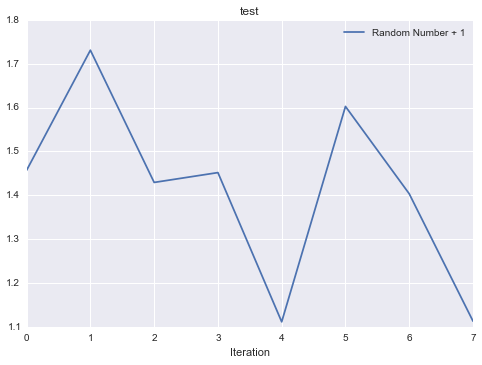

In [6]:
experiment.start()
experiment.plot_live('Iteration', 'Random Number + 1')

Analysed data

In [7]:
experiment.data

,Iteration,Random Number,Random Number + 1,Random Number + 2
0,0,0.456978,1.456978,2.456978
1,1,0.730885,1.730885,2.730885
2,2,0.429307,1.429307,2.429307
3,3,0.451717,1.451717,2.451717
4,4,0.111348,1.111348,2.111348
5,5,0.602626,1.602626,2.602626
6,6,0.403370,1.403370,2.403370
7,7,0.112884,1.112884,2.112884
8,8,0.065779,1.065779,2.065779
9,9,0.656756,1.656756,2.656756


Raw data (as saved on disk)

In [8]:
experiment.results.data

,Iteration,Random Number,Random Number + 1
0,0,0.456978,1.456978
1,1,0.730885,1.730885
2,2,0.429307,1.429307
3,3,0.451717,1.451717
4,4,0.111348,1.111348
5,5,0.602626,1.602626
6,6,0.403370,1.403370
7,7,0.112884,1.112884
8,8,0.065779,1.065779
9,9,0.656756,1.656756


Filename generated by config preferences

In [9]:
experiment.filename

'/Users/Guen/Development/pymeasure/examples/data/2016-02-10/my_data_20160210_133802_test.csv'